# pycbf - Basic example

This notebook roughly simulates channel data and beamforms it

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import ctypes as ct

## Generating channel data

In [3]:
# channel data parameters
fc = 5E6        # centerfrequency of plane wave excitation [Hz]
fs =  6 * fc    # sampling frequency [Hz]
c = 1540        # speed of sound [m/s]
lam = c/fc      # wavelength [m]

nele = 64       # number of elements in probe
dele = lam      # probe spacing [m]

# locations of elements
xele = dele*(np.arange(nele) - (nele-1)/2)
yele = 0
zele = 0
Xele, Yele, Zele = np.meshgrid(xele, yele, zele, indexing='ij')
eles = np.array([Xele.flatten(), Yele.flatten(), Zele.flatten()]).T

# reconstruction grid
xgrid = dele*(np.arange(0, nele, 1/2) - (nele-1)/2)
ygrid = 0
zgrid = np.arange(1*lam, nele*dele, lam/8)
Xgrid, Ygrid, Zgrid = np.meshgrid(xgrid, ygrid, zgrid, indexing='ij')
grid = np.array([Xgrid.flatten(), Ygrid.flatten(), Zgrid.flatten()]).T

## Calculate the full synthetic aperture using a point-like assumption

In [4]:
# location of point scatterer
pointa = np.array([[nele*dele/8, 0, nele*dele/4]])
pointb = np.array([[-nele*dele/7, 0, nele*dele/3]])
pointc = np.array([[0, 0, 2*nele*dele/7]])

rf = 0
for point in [pointa, pointb, pointc]:
    # time delays between each element and the point
    tau = np.linalg.norm(eles - point, axis=-1)/c

    # generate all (realtive) time points for each pulse
    tmax = 2*np.sqrt((dele * (nele-1))**2 + (nele*dele)**2)/c
    t = np.arange(0, tmax, 1/fs)

    # calculate all delay tabs
    T = t[None,None,:] - (tau[:,None,None] + tau[None,:,None])

    # make rf data from tabs
    rf += sig.gausspulse(t=T, fc=fc, bw=0.75)

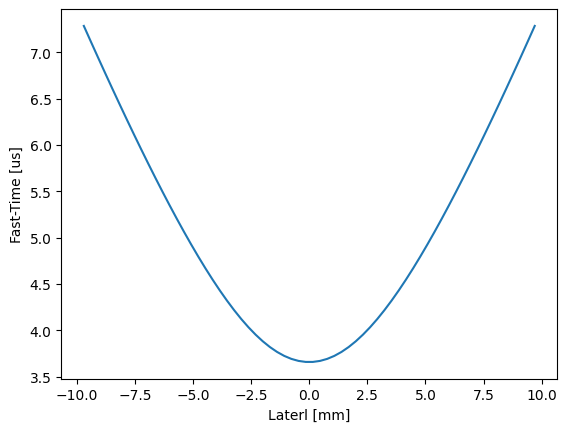

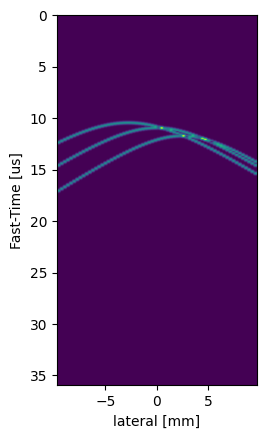

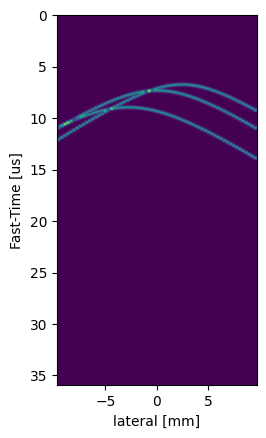

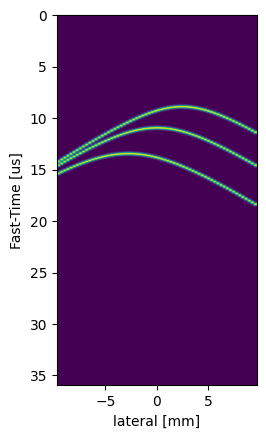

In [5]:
# plot delay tabs
plt.figure()
plt.plot(1E3*xele, 1E6*tau.flatten())
plt.xlabel("Laterl [mm]")
plt.ylabel("Fast-Time [us]")
plt.show()

env = np.abs(sig.hilbert(rf, axis=-1))
plt.figure()
plt.imshow(env[0,:,:].T, extent=[1E3*xele[0], 1E3*xele[-1], 1E6*t.flatten()[-1], 0])
plt.xlabel("lateral [mm]")
plt.ylabel("Fast-Time [us]")
plt.show()

plt.figure()
plt.imshow(env[nele//2,:,:].T, extent=[1E3*xele[0], 1E3*xele[-1], 1E6*t.flatten()[-1], 0])
plt.xlabel("lateral [mm]")
plt.ylabel("Fast-Time [us]")
plt.show()

plt.figure()
plt.imshow(env[-1,:,:].T, extent=[1E3*xele[0], 1E3*xele[-1], 1E6*t.flatten()[-1], 0])
plt.xlabel("lateral [mm]")
plt.ylabel("Fast-Time [us]")
plt.show()

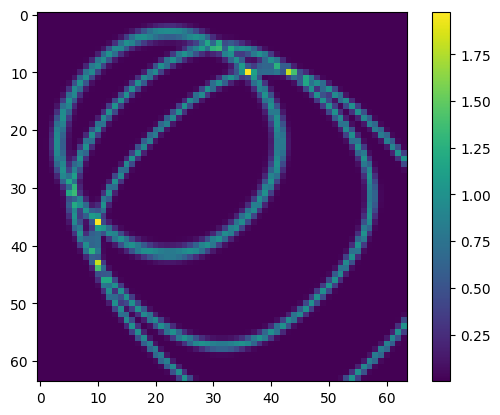

In [6]:
plt.figure()
plt.imshow(env[:,:,np.argmin(np.abs(t-10E-6))].T)
plt.colorbar()
plt.show()

In [7]:
dXvec = grid[None,:,:] - eles[:,None,:]
fnum = 1
tautxrx = np.linalg.norm(dXvec, axis=-1)/c
apodrect = np.abs(dXvec[:,:,0]) - dXvec[:,:,2]/(2*fnum) < 0

from pycbf import SimpleBeamformer

In [8]:
eles.shape, grid.shape, apodrect.shape

((64, 3), (64512, 3), (64, 64512))

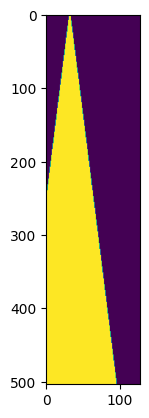

In [9]:
plt.figure()
plt.imshow(apodrect[16].reshape(Xgrid.shape[0], Xgrid.shape[-1]).T)
plt.show()

In [10]:
from tqdm.notebook import tqdm

In [11]:
bf = SimpleBeamformer(
    tautx=tautxrx, 
    taurx=tautxrx,
    apodtx=apodrect,
    apodrx=apodrect
)

im = 0
for aline in tqdm(bf.__map_aline__(rf, t), total=bf.ntx*bf.nrx):
    im += bf.__beamform_single__(*aline)

  0%|          | 0/4096 [00:00<?, ?it/s]

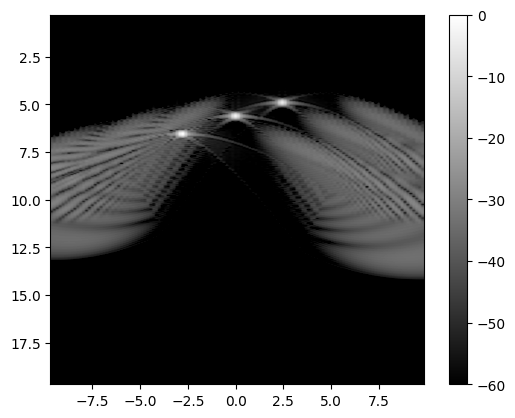

In [12]:
imrect = im.reshape(Xgrid.shape[0], Xgrid.shape[-1])
envrect = np.abs(sig.hilbert(imrect, axis=-1)).T

logged = 20*np.log10(envrect/np.max(envrect))

ex_bmode = 1E3*np.array([xgrid[0], xgrid[-1], zgrid[-1], zgrid[0]])

plt.figure()
plt.imshow(logged, vmin=-60, vmax=0, cmap='gray', extent=ex_bmode)
plt.colorbar()
plt.show()

In [13]:
rf.shape

(64, 64, 1078)

In [14]:
pnt_tau  = [np.array(subtau, copy=True).astype(ct.c_float).ctypes.data_as(ct.POINTER(ct.c_float)) for subtau in tautxrx]
pnt_apod = [np.array(subapod, copy=True).astype(ct.c_float).ctypes.data_as(ct.POINTER(ct.c_float)) for subapod in apodrect]
pnt_out  = np.zeros(len(apodrect[nele//2]), dtype=ct.c_float).ctypes.data_as(ct.POINTER(ct.c_float))
pnt_sig  = []
for itx in range(nele):
    subsig = []
    for irx in range(nele):
        subsig.append(np.array((1/(1E-9+t))*rf[itx,irx], copy=True).astype(ct.c_float).ctypes.data_as(ct.POINTER(ct.c_float)))
    pnt_sig.append(subsig)

In [15]:
import pycbf.cpu as pbfcpu

In [16]:
len(pnt_sig), len(pnt_sig[0]), rf.shape, nele, pnt_out

(64, 64, (64, 64, 1078), 64, <__main__.LP_c_float at 0x7f1286a0d050>)

In [17]:
for itx in range(nele):
    for irx in range(nele):
        pbfcpu.__cpu_pycbf__.beamform(
            ct.c_float(t[0]), 
            ct.c_float(t[1]-t[0]), 
            ct.c_int(len(t)), 
            pnt_sig[itx][irx],
            ct.c_int(apodrect.shape[1]),
            pnt_tau[itx],
            pnt_apod[itx],
            pnt_tau[irx],
            pnt_apod[irx],
            pnt_out
        )

In [18]:
output = []
for ivec in range(apodrect.shape[1]):
    output.append(pnt_out[ivec])

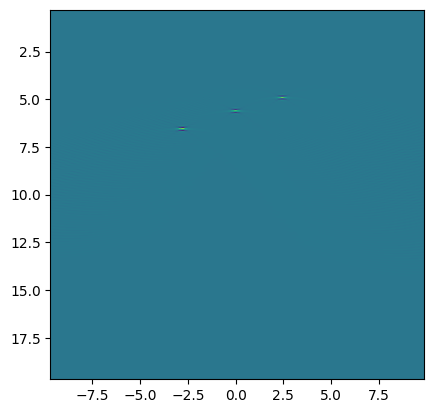

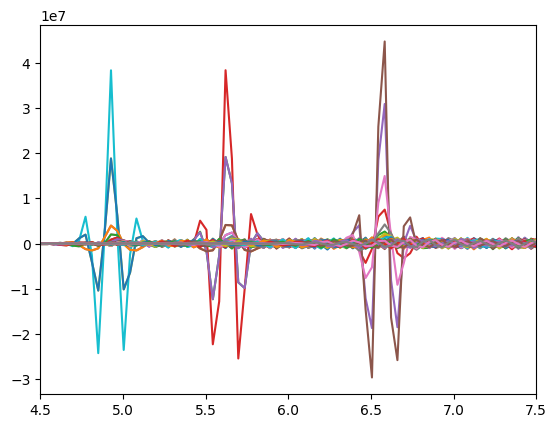

In [19]:
rectrf = np.array(output).reshape(Xgrid.shape).squeeze().T

plt.figure()
plt.imshow(rectrf, extent=ex_bmode)
plt.show()

plt.figure()
plt.plot(1E3*zgrid, rectrf)
plt.xlim(4.5, 7.5)
plt.show()

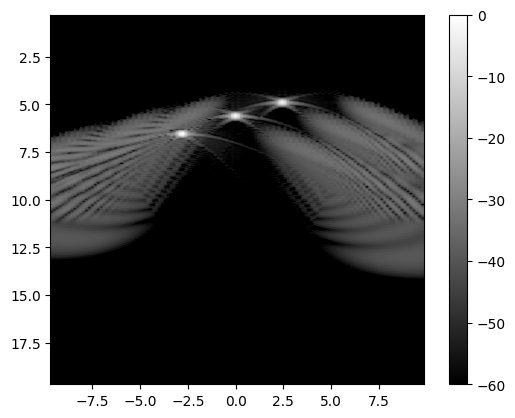

In [20]:
envrect = np.abs(sig.hilbert(rectrf, axis=0))

logged = 20*np.log10(envrect/np.max(envrect))

ex_bmode = 1E3*np.array([xgrid[0], xgrid[-1], zgrid[-1], zgrid[0]])

plt.figure()
plt.imshow(logged, vmin=-60, vmax=0, cmap='gray', extent=ex_bmode)
plt.colorbar()
plt.show()

In [21]:
pnt_rf = tautxrx.astype(ct.c_float).ctypes.data_as(ct.POINTER(ct.c_float))

In [22]:
def offset_pnt(pnt, offset):
    from ctypes import sizeof, cast, POINTER
    pvoid = cast(pnt, ct.c_void_p)
    pvoid.value += offset * sizeof(pnt._type_)
    pnt_out = cast(pvoid, POINTER(pnt._type_))

    return pnt_out

In [23]:
pnt_rf_inc = offset_pnt(pnt_rf, 8)
pnt_rf[0], pnt_rf[8], pnt_rf_inc[0], pnt_rf._type_

(2.0000000233721948e-07,
 4.0000000467443897e-07,
 4.0000000467443897e-07,
 ctypes.c_float)

In [24]:
p = ct.cast(pnt_rf, ct.c_void_p)
print(p)
p.value += ct.sizeof(ct.c_float)
print(p)
pnt_inc = ct.cast(p, ct.POINTER(ct.c_float))
print(pnt_inc[0])

c_void_p(1201024720)
c_void_p(1201024724)
2.2499999374758772e-07


In [25]:
import multiprocessing as mp
arr = mp.RawArray(ct.c_float, rf.flatten())



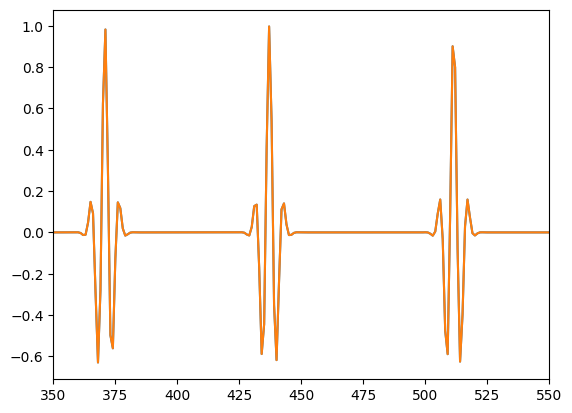

In [26]:
sub = arr[:rf.shape[-1]]
plt.figure()
plt.plot(sub)
plt.plot(rf[0,0])
plt.xlim(350, 550)
plt.show()

In [30]:
from dataclasses import dataclass
from pycbf.Beamformer import Beamformer, BeamformerException, __BMFRM_PARAMS__
from numpy import ndarray

class CPUBeamformer(Beamformer):
    nwrkr : int = 8

    def __post_init__(self):
        super().__post_init__()
        from multiprocessing import RawArray
        from ctypes import c_float

        # Access the global shared buffer
        params = __BMFRM_PARAMS__[self.id]

        # copy tx/rx/output point dimensions
        params['ntx'] = self.ntx
        params['nrx'] = self.nrx
        params['nop'] = self.nop

        # the ctype being used, might eb flexible in future
        c_type = c_float

        # copy the tabs
        params['pttx'] = RawArray(c_type, self.tautx.flatten())
        params['ptrx'] = RawArray(c_type, self.taurx.flatten())
        params['patx'] = RawArray(c_type, self.apodtx.flatten())
        params['parx'] = RawArray(c_type, self.apodrx.flatten())

        # build an output buffer for each worker
        params['results'] = {}
        for ii in range(self.nwrkr):
            params['results'][ii] = RawArray(c_type, self.nop)

    @staticmethod
    def __offset_pnt__(pnt, offset:int):
        from ctypes import sizeof, cast, POINTER

        # convert to a void-type pointer object
        pvoid = cast(pnt, ct.c_void_p)

        # calculate the element offset in bytes
        pvoid.value += int(offset * sizeof(pnt._type_))

        # reform the pointer as its original type
        pnt_out = cast(pvoid, POINTER(pnt._type_))

        return pnt_out


    @staticmethod
    def __beamform_single__(id, itx, irx):
        """Use the identified beamformer to beamform the aline specified by tx and rx indices"""
        from numpy import ravel_multi_index
        from pycbf.cpu import __cpu_pycbf__

        params = __BMFRM_PARAMS__[id]

        iwrkr = params['idx']
        ntx   = params['ntx']
        nrx   = params['nrx']
        nop   = params['nop']

        t0    = params['t0']
        dt    = params['dt']
        nt    = params['nt']

        txoff = ravel_multi_index((itx,0), (ntx,nop))
        rxoff = ravel_multi_index((irx,0), (nrx,nop))
        rfoff = ravel_multi_index((itx,irx,0), (ntx,nrx,nt))

        pttx = CPUBeamformer.__offset_pnt__(params['pttx'], txoff)
        ptrx = CPUBeamformer.__offset_pnt__(params['ptrx'], rxoff)
        patx = CPUBeamformer.__offset_pnt__(params['patx'], txoff)
        parx = CPUBeamformer.__offset_pnt__(params['parx'], rxoff)
        psig = CPUBeamformer.__offset_pnt__(params['psig'], rfoff)

        out  = params['results'][iwrkr]

        __cpu_pycbf__.beamform(
            ct.c_float(t0), ct.c_float(dt), ct.c_int(nt), psig,
            ct.c_int(nop), pttx, patx, ptrx, parx, out
        )

    @staticmethod
    def __mp_init_workers__(id, queue):
        __BMFRM_PARAMS__[id]['idx'] = queue.get()

    def __start_pool__(self):
        """Make the multiprocessing pool"""
        from multiprocessing import Pool, Manager

        if hasattr(self, "pool"): return

        # use a process-shared queue to link workers with a persistent buffer
        manager = Manager()
        idQueue = manager.Queue()
        for i in range(self.nwrkr): idQueue.put(i)

        # setup the pool
        self.pool = Pool(
            self.nwrkr, 
            initializer=self.__mp_init_workers__,
            initargs=(self.id, idQueue,)
        )

    def __kill_pool__(self):
        if hasattr(self, "pool"): self.pool.terminate()

    def __zero_buffers__(self):
        from ctypes import memset, sizeof
        params = __BMFRM_PARAMS__[self.id]
        for iwrkr in range(self.nwrkr):
            memset(params['results'][iwrkr], 0, int(self.nop*sizeof(params['results'][iwrkr]._type_)))
        
    def __call__(self, txrxt:ndarray, t:ndarray):
        from multiprocessing import RawArray
        from itertools import product
        from ctypes import c_float

        # ensure input data meets data specs
        if txrxt.shape != (self.ntx, self.nrx, len(t)):
            raise BeamformerException(f"Input data must be {self.ntx} by {self.nrx} by {len(t)}")
        
        params = __BMFRM_PARAMS__[self.id]

        params['psig'] = RawArray(c_float, txrxt.flatten())
        params['t0']   = t[0]
        params['dt']   = t[1] - t[0]
        params['nt']   = len(t)

        self.__zero_buffers__()

        # delay and apodize
        self.__start_pool__()
        self.pool.starmap(CPUBeamformer.__beamform_single__, product([self.id], range(itx), range(irx)))

        temp = np.array([params['results'][id][:self.nop] for id in range(self.nwrkr)])

        return np.sum(temp, axis=0)

    def __del__(self):
        self.__kill_pool__()

bfcpu = CPUBeamformer(
    tautx=tautxrx, 
    taurx=tautxrx,
    apodtx=apodrect,
    apodrx=apodrect
)

In [31]:
res = bfcpu(rf, t)

# from numpy import ravel_multi_index
# ntx=128
# nrx=128
# nop=apodrect.shape[1]
# nt=len(t)

# txoff = ravel_multi_index((itx,0), (ntx,nop))
# rxoff = ravel_multi_index((irx,0), (nrx,nop))
# rfoff = ravel_multi_index((itx,irx,0), (ntx,nrx,nt))

# txoff, rxoff, rfoff

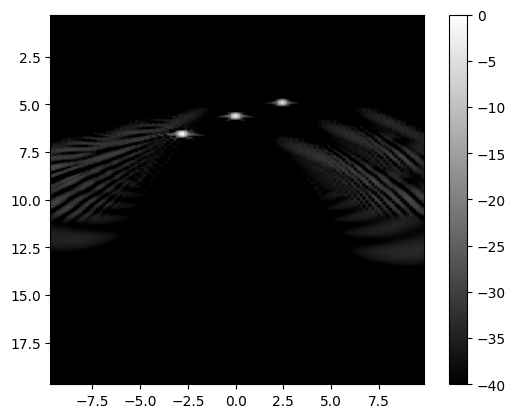

In [33]:
imrect = res.reshape(Xgrid.shape).squeeze().T
envrect = np.abs(sig.hilbert(imrect, axis=0))

logged = 20*np.log10(envrect/np.max(envrect))

ex_bmode = 1E3*np.array([xgrid[0], xgrid[-1], zgrid[-1], zgrid[0]])

plt.figure()
plt.imshow(logged, vmin=-40, vmax=0, cmap='gray', extent=ex_bmode)
plt.colorbar()
plt.show()